In [1]:
#%env SM_FRAMEWORK=tf.keras

In [1]:
import os
import numpy as np
import imageio
from matplotlib import pyplot as plt

import segmentation_models as sm
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

import tensorflow as tf
import keras
import cv2

from tensorflow.keras.layers import Input, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import albumentations as A

Segmentation Models: using `keras` framework.


In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# classes for data loading and preprocessing
class Dataset:

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None
    ):
        all_ids = os.listdir(images_dir)
        self.ids = [x for x in all_ids if x!='.ipynb_checkpoints']
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=2)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=2)
        
        image = image/255.
        mask = mask/255.
        
        image = np.array(image, dtype = np.float32)
        mask = np.array(mask, dtype = np.float32)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']    
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = tuple([np.stack(samples, axis=0) for samples in zip(*data)])
        #batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [4]:
x_test_dir = "test_data/images"
y_test_dir = "test_data/labels"

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir
)


test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)


In [5]:
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

In [6]:
bb = "vgg16"
input_shape = (256,256,3)
c = 1
enc_weights = "imagenet"
base_model = sm.Unet(backbone_name = bb, input_shape = input_shape, classes = c, activation='sigmoid', encoder_weights = enc_weights)

# define number of channels
N = 1
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
# now set the dropout rate to 0.
drop = Dropout(0.)(l1)
bm = base_model(drop)
out = Dropout(0.)(bm)


lr = 0.0001
optim = Adam(lr)

w = np.array([1,1])
loss = DiceLoss(class_weights=w)
metrics = IOUScore(class_weights=w)

modelUnet = Model(inp, out, name=base_model.name)

modelUnet.compile(optim, loss=loss, metrics=[metrics])

In [8]:
modelUnet.load_weights("models_result/vgg16_100epochs_batch4/modelUnet_ring_dropout_vgg16_best.h5")

In [9]:
y_pred = modelUnet.predict(test_dataloader)

In [10]:
y_pred.shape

(234, 256, 256, 1)

In [11]:
test_dataloader[0][0].shape

(1, 256, 256, 1)

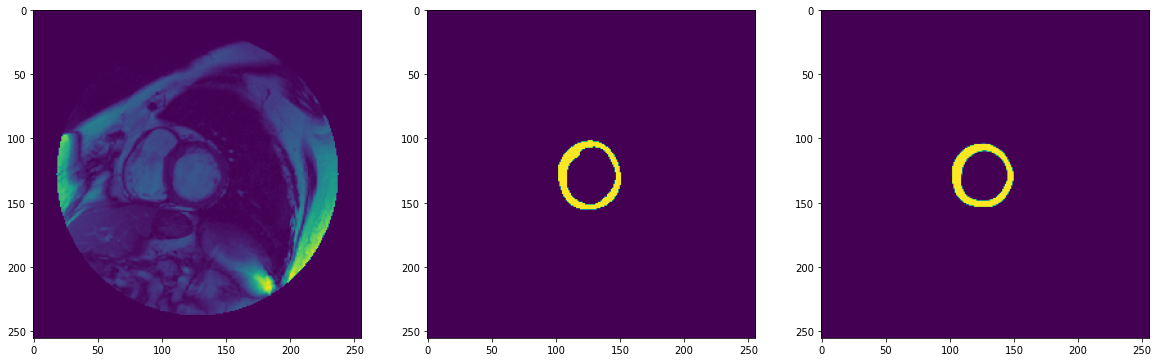

In [16]:
n = 214
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(test_dataloader[n][0][0,:,:,0])
plt.subplot(1,3,2)
plt.imshow(test_dataloader[n][1][0,:,:,0])
plt.subplot(1,3,3)
plt.imshow(y_pred[n,:,:,0])

In [22]:
test_dataloader_new = Dataloder(test_dataset, batch_size=234, shuffle=False)

In [25]:
loss(y_pred, test_dataloader_new[0][1]).numpy()

0.16413695

In [26]:
metrics(y_pred, test_dataloader_new[0][1]).numpy()

0.718012